In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from math import sqrt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings(action='ignore')

# 시각화
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use(["seaborn-v0_8-muted"])
plt.rc('font', family='Malgun Gothic')
matplotlib.rc('axes',unicode_minus=False)
seaborn_style = [style for style in matplotlib.style.available if "seaborn" in style]
from tqdm import tqdm

# 모델
import joblib
from pycaret.regression import *
from pycaret.regression import load_model

from sklearnex import patch_sklearn
patch_sklearn()
from lightgbm import plot_importance
from lightgbm.sklearn import LGBMRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.samplers import TPESampler
from functools import partial

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import torch 
### 토치확인
print("pytorch cuda 여부")
print(torch.cuda.is_available())
print('#'*50)

from tensorflow.python.client import device_lib
print("tensorflow cuda 여부")
print(device_lib.list_local_devices())
print('#'*50)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # -1이면 cpu사용

pytorch cuda 여부
True
##################################################
tensorflow cuda 여부
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13806903403038363093
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8579174871969740088
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
##################################################


# Data download

In [3]:
# 따로 실행하거나, 주석해제하고 실행
# !python Collect_data.py
# !python Prepare_data.py

# 모델링

In [81]:
ppd_data=pd.read_csv('../data/ppd_data.csv')
ppd_data.set_index("ymdhm",inplace=True)
ppd_data.index=pd.to_datetime(ppd_data.index)

answer=pd.read_csv("../data/2023_answer.csv")
answer['ymdhm']=pd.to_datetime(answer['ymdhm'])
answer.set_index('ymdhm',inplace=True)

# Baseline model

임의의 bridge 하나를 선택해서 어떤 모델이 좋을 지 baseline model을 선택하기 위함. <br>
-> 중간에 있는 jamsu교를 target으로 하였음.

In [ ]:
tmp=ppd_data.copy()

TARGET_BRIDGE = 'wl_jamsu'
tmp["prev_"+TARGET_BRIDGE]=tmp[TARGET_BRIDGE].copy()
X_train = tmp.drop(columns=[TARGET_BRIDGE]).shift(1)
X_train = X_train.iloc[1:]
y_train = tmp[TARGET_BRIDGE].iloc[1:]
train=pd.concat([X_train,y_train],axis=1)


# 모델을 선정하기위해 automl pycaret을 이용하여 선정. -> 한대교만을 기준으로 선정하였음. 
#test = setup(data=train, target='wl_jamsu', fold_strategy = 'kfold',fold=5, data_split_shuffle=True, use_gpu=True, verbose=False)
#res = compare_models(include = ['lightgbm','xgboost','catboost','rf'], sort='rmse')
#res

# model train & tune & inference

In [83]:
# 해당 폴더에 파일이 있는지 없는지 확인
def check_file(path):
    return os.path.isfile(path)
# 평가지수 rmse/r_squared
def metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r_squared = r2_score(y_true, y_pred)
    score=rmse/r_squared
    
    return 'score', score, False

In [84]:
def feature_importance(leadtime,month, max_n):
    """
    lgbm 모델의 feature importance를 불러오는 함수.
    """
    fig=plt.figure(figsize=(10,6))
    model = joblib.load(f'../model/leadtime({leadtime})/tuned_model(month={month}).pkl')
    importance = plot_importance(model, max_num_features=max_n, figsize=(6, 4))
    plt.title(f'month={month}, leadtime={leadtime} feature importance')
    return fig

def plot_compare(answer_data,pred_data):
    """
    실제 데이터와 예측 데이터를 비교하여 시각화해주는 함수
    1. scatter plot /  2. line plot
    """
    # 오차(rmse) 계산
    rmse = mean_squared_error(answer_data[TARGET_BRIDGE], pred_data['pred_target'], squared=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Scatter plot
    ax1.scatter(answer_data[TARGET_BRIDGE], pred_data['pred_target'])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Actual vs. Predicted Water Levels')
    ax1.set_aspect('equal', adjustable='box')

    # Line plot
    ax2.text(0.05, 0.95, '  {:.3f}  '.format(rmse),fontsize=30, ha='right', va='top', transform=ax2.transAxes)
    ax2.plot(answer_data.index, answer_data[TARGET_BRIDGE], label='Actual', color='blue', alpha=0.5)
    ax2.plot(answer_data.index, pred_data['pred_target'], label='Predicted', color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Water Level')
    ax2.set_title('Actual vs. Predicted Water Levels')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [85]:
def plot_month(answer_data,pred_data,len_m):
    """
    1. scatter plot: 실제 데이터와 예측 데이터의 오차를 월별로 보여주는 함수
    2. bar plot: 예측 데이터의 오차를 월별로 보여주는 함수 
    
    """
    used_data=pd.concat([answer_data,pred_data],axis=1)
    used_data.index=pd.to_datetime(used_data.index)

    grouped = used_data.groupby(used_data.index.month)
    year = used_data.index[0].year

    fig, axes = plt.subplots(nrows=len_m//2, ncols=2, figsize=(20, len_m*2))
    axes = axes.ravel()  
    month_names = ["January", "February", "March", "April", "May", "June", "July", "August", 
                "September", "October", "November", "December"]

    month_rmse = []
    
    # Line plot
    for (month, m_data), ax in zip(grouped, axes):
        actual = m_data[TARGET_BRIDGE]
        predicted = m_data['pred_target']
        
        rmse = mean_squared_error(actual, predicted, squared=False)
        month_rmse.append(rmse)
        
        ax.plot(m_data.index, actual, label='Actual', color='blue', alpha=0.5)
        ax.plot(m_data.index, predicted, label='Predicted', color='red', linestyle='--', alpha=0.5)
        ax.set_title(f'{TARGET_BRIDGE}{month_names[month-1]}, {year} - RMSE: {rmse:.2f}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Water Level')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.title(f'{TARGET_BRIDGE} PREDICT')
    plt.show();
    
    # Bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(month_rmse)), month_rmse, color='skyblue', edgecolor='black')
    plt.ylabel('RMSE')
    plt.xlabel('Month')
    plt.title(f'RMSE by Month for {year}')
    plt.xticks(range(len(month_rmse)), [month_names[i-1] for i in grouped.groups.keys()], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();


In [86]:
def prepare_datasets(input_data, leadtime, month_list):
    """
    Parameters:
    - input_data: 2023 제외한 특정 month 데이터 
    - leadtime: 선행시간
    - month_list: 학습하고자하는 month 

    Returns:
    - X_train: 학습 데이터 features
    - y_train: 학습 데이터 target
    """
    
    X_train = input_data.drop(columns=[TARGET_BRIDGE]).shift(leadtime//10)

    y_train = input_data[TARGET_BRIDGE].iloc[leadtime//10:]

    X_train = X_train.iloc[leadtime//10:]
    
    X_train=X_train[X_train['month'].isin(month_list)]
    y_train=y_train[X_train.index]

    return X_train, y_train

In [87]:
def make_base_model(train_data):
    """
    Parameters:
    - train_data: 학습 데이터 
    - leadtime: 선행시간

    Returns:
    - model: 베이스라인 모델(성능비교용)
    """
    
    params={
        "num_leaves" : 1023,
        "max_depth" : 15,
        "learning_rate" : 0.23,
        "n_estimators": 50,
        "min_child_samples" :10,
        "reg_lambda" : 7,
        "colsample_bytree" : 0.5,
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(train_data[0], train_data[1], test_size=0.2, random_state=624)

    model = LGBMRegressor(**params,random_state=624,objective= 'rmse',device='gpu',verbose=-1)
    model.fit(X_train,y_train, eval_set=[(X_valid, y_valid)], eval_metric=metrics)
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration_)
    print(f'Valid Score: {metrics(y_valid, y_pred)[1]}')
    
    return model

In [88]:
class EarlyStoppingCallback(object):
    # stackoverflow에서 가져옴. https://github.com/optuna/optuna/issues/1001
    # optuna의 early stopping callback 적용
    # 평가지수가 감소하는 방향으로 학습하면 minimize
    # 평가지수가 증가하는 방향으로 학습하면 maximize

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds
        self._iter = 0
        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

# optuna의 목적함수
def objective(trial, X, y):
    
    params_optuna={
        "num_leaves" : trial.suggest_categorical('num_leaves',[2**9-1, 2**10-1, 2**11-1]),
        "max_depth" : trial.suggest_int('max_depth',7,25),
        "learning_rate" : trial.suggest_float('learning_rate',0.01,0.1),
        "n_estimators": trial.suggest_int('n_estimators',50,600),
        "min_child_samples" : trial.suggest_int('min_child_samples',10,25),
        "reg_lambda" : trial.suggest_float('reg_lambda',5.0,20.0),
        "colsample_bytree"  : trial.suggest_categorical('colsample_bytree',[0.5,0.7]),
        "device":'gpu',
    }
    model = LGBMRegressor(**params_optuna,verbose=-1)

    folds = KFold(n_splits=5, random_state=624, shuffle=True)
    losses = []

    for train_idx, valid_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_valid = X.iloc[valid_idx, :]
        y_valid = y.iloc[valid_idx]

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=metrics)
        preds = model.predict(X_valid)
        
        loss =  mean_squared_error(y_valid, preds,squared=False)
        losses.append(loss)
        
    return np.mean(losses)

def make_tune_model(train_data):
    
    # optuna에 인자를 넘기고 싶을 경우
    opt_func = partial(objective, X=train_data[0], y=train_data[1]) 

    K = 5 
    sampler = TPESampler(seed=624)
    
    study = optuna.create_study(direction="minimize", # 최소/최대 어느 방향의 최적값을 구할 건지.
                                sampler=sampler,
                                storage="sqlite:///recorddb.sqlite3",
                                load_if_exists=True) 
    early_stopping = EarlyStoppingCallback(15, direction='minimize')
    study.optimize(opt_func, n_trials=100, callbacks=[early_stopping])
    
    print("Tuned train Score: %.4f" % study.best_value) # best score 출력
    print("Tuned params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들
    
    best_params = study.best_params
    best_model = LGBMRegressor(**best_params,random_state=624,objective= 'rmse',device='gpu', verbose=-1)
    best_model.fit(train_data[0], train_data[1])
    
    return best_model

In [89]:
def get_model_input(data, leadtime):
    
    # 특정 시점의 데이터를 예측하기 위한, 학습 데이터 준비 
    start_time = datetime(2023, 1, 1) - timedelta(minutes=leadtime)
    
    input_data = data[data.index >= start_time.strftime('%Y-%m-%d %H:%M:%S')]
    
    input_data.drop([TARGET_BRIDGE],axis=1,inplace=True)
    
    return input_data

def make_pred(data, leadtime, month_list, filename):
    """
    특정월로 학습된 모델로 전체를 예측한 뒤, 
    특정월 결과만 가져올 것.
    """
    input_data = get_model_input(data, leadtime)
    model = joblib.load(f'../model/{TARGET_BRIDGE}/leadtime({leadtime})/tuned_model({filename}).pkl')
    y_pred = model.predict(input_data,verbose=0)
    y_pred=pd.DataFrame(y_pred[:-(leadtime//10)],index=answer.index,columns=['pred_target'])
    y_pred.index=pd.to_datetime(y_pred.index)
    y_pred['month']=y_pred.index.month
    y_pred=y_pred[y_pred['month'].isin(month_list)]
    
    return y_pred

In [90]:
def predict_wl_level(train_data,data,month_list,leadtime,filename):
    print("#"*50)
    print(f"{TARGET_BRIDGE} {filename}({leadtime}) predict start")
    monthly_train= prepare_datasets(train_data,leadtime,month_list)
    if(check_file(f"../model/{TARGET_BRIDGE}/leadtime({leadtime})/tuned_model({filename}).pkl")!=1):
        base_model=make_base_model(monthly_train)
        #joblib.dump(base_model, f'../model/leadtime({leadtime})/base_model(month={month}).pkl')
        best_model=make_tune_model(monthly_train)
        joblib.dump(best_model, f"../model/{TARGET_BRIDGE}/leadtime({leadtime})/tuned_model({filename}).pkl")
    pred=make_pred(data,leadtime,month_list,filename)
    pred.to_csv(f'../result/{TARGET_BRIDGE}/leadtime({leadtime})/(lt={leadtime},{filename})_predict.csv')
    print(f"{TARGET_BRIDGE} {filename}({leadtime}) predict end")
    return pred

def train_option(data,leadtime,opt):
    
    os.makedirs(f"../model/{TARGET_BRIDGE}/leadtime({leadtime})",exist_ok=True)
    os.makedirs(f"../result/{TARGET_BRIDGE}/leadtime({leadtime})",exist_ok=True)
    
    data["prev_"+TARGET_BRIDGE]=data[TARGET_BRIDGE].copy()
    train_data = data[:f"2023-01-01 00:00:00"]
    
    print("#"*100)
    print("#"*100)
    print(f"{TARGET_BRIDGE} Leadtime {leadtime} modeling start")
    
    #opt=int(input())
    tmp_result=[]
    # 각 월마다 따로 학습 및 병합
    if(opt==1):
        for month in range(1,10):
            pred=predict_wl_level(train_data,data,[month],leadtime,f"month={month}")
            tmp_result.append(pred)
    # 홍수기와 비홍수기 나눠서 학습 및 병합
    elif(opt==2):
        # 비홍수기
        month=[1,2,3,4,5,10,11,12]
        pred=predict_wl_level(train_data,data,month,leadtime,f"비홍수기")
        tmp_result.append(pred)
        
        month=[6,7,8,9]
        pred=predict_wl_level(train_data,data,month,leadtime,f"홍수기")
        tmp_result.append(pred)
    # 전체 월로 학습 
    elif(opt==3):
        month=[1,2,3,4,5,6,7,8,9,10,11,12]
        pred=predict_wl_level(train_data,data,month,leadtime,f"전체")
        tmp_result.append(pred)
        
    final_result = pd.concat(tmp_result)
    final_result.drop(['month'],axis=1,inplace=True)
    
    return final_result
      

In [95]:
ppd_data=pd.read_csv('../data/ppd_data.csv')
ppd_data.set_index("ymdhm",inplace=True)
ppd_data.index=pd.to_datetime(ppd_data.index)

answer=pd.read_csv("../data/2023_wl_answer.csv")
answer['ymdhm']=pd.to_datetime(answer['ymdhm'])
answer.set_index('ymdhm',inplace=True)

## 청담대교 모델학습 및 추론(2023 1~9월)

In [96]:
TARGET_BRIDGE='wl_cheongdam'
cheongdam_lt10_monthly = train_option(ppd_data,10,1)
cheongdam_lt10_flood= train_option(ppd_data,10,2)
cheongdam_lt10_total = train_option(ppd_data,10,3)

####################################################################################################
####################################################################################################
wl_cheongdam Leadtime 10 modeling start
##################################################
wl_cheongdam month=1(10) predict start
wl_cheongdam month=1(10) predict end
##################################################
wl_cheongdam month=2(10) predict start
wl_cheongdam month=2(10) predict end
##################################################
wl_cheongdam month=3(10) predict start
wl_cheongdam month=3(10) predict end
##################################################
wl_cheongdam month=4(10) predict start
wl_cheongdam month=4(10) predict end
##################################################
wl_cheongdam month=5(10) predict start
wl_cheongdam month=5(10) predict end
##################################################
wl_cheongdam month=6(10) predict start
wl_cheongdam month=6(10) predict 

## 잠수교 모델학습 및 추론(2023 1~9월)

In [97]:
TARGET_BRIDGE='wl_jamsu'
jamsu_lt10_monthly = train_option(ppd_data,10,1)
jamsu_lt10_flood= train_option(ppd_data,10,2)
jamsu_lt10_total = train_option(ppd_data,10,3)

####################################################################################################
####################################################################################################
wl_jamsu Leadtime 10 modeling start
##################################################
wl_jamsu month=1(10) predict start
wl_jamsu month=1(10) predict end
##################################################
wl_jamsu month=2(10) predict start
wl_jamsu month=2(10) predict end
##################################################
wl_jamsu month=3(10) predict start
wl_jamsu month=3(10) predict end
##################################################
wl_jamsu month=4(10) predict start
wl_jamsu month=4(10) predict end
##################################################
wl_jamsu month=5(10) predict start
wl_jamsu month=5(10) predict end
##################################################
wl_jamsu month=6(10) predict start
wl_jamsu month=6(10) predict end
################################################

## 행주대교 모델학습 및 추론(2023 1~9월)

In [98]:
TARGET_BRIDGE='wl_haengju'
haengju_lt10_monthly = train_option(ppd_data,10,1)
haengju_lt10_flood= train_option(ppd_data,10,2)
haengju_lt10_total = train_option(ppd_data,10,3)

####################################################################################################
####################################################################################################
wl_haengju Leadtime 10 modeling start
##################################################
wl_haengju month=1(10) predict start
wl_haengju month=1(10) predict end
##################################################
wl_haengju month=2(10) predict start
wl_haengju month=2(10) predict end
##################################################
wl_haengju month=3(10) predict start
wl_haengju month=3(10) predict end
##################################################
wl_haengju month=4(10) predict start
wl_haengju month=4(10) predict end
##################################################
wl_haengju month=5(10) predict start
wl_haengju month=5(10) predict end
##################################################
wl_haengju month=6(10) predict start
wl_haengju month=6(10) predict end
######################

## 한강대교 모델학습 및 추론(2023년 1~9월)

In [99]:
TARGET_BRIDGE='wl_hangang'
hangang_lt10_monthly = train_option(ppd_data,10,1)
hangang_lt10_flood= train_option(ppd_data,10,2)
hangang_lt10_total = train_option(ppd_data,10,3)

####################################################################################################
####################################################################################################
wl_hangang Leadtime 10 modeling start
##################################################
wl_hangang month=1(10) predict start
wl_hangang month=1(10) predict end
##################################################
wl_hangang month=2(10) predict start
wl_hangang month=2(10) predict end
##################################################
wl_hangang month=3(10) predict start
wl_hangang month=3(10) predict end
##################################################
wl_hangang month=4(10) predict start
wl_hangang month=4(10) predict end
##################################################
wl_hangang month=5(10) predict start
wl_hangang month=5(10) predict end
##################################################
wl_hangang month=6(10) predict start
wl_hangang month=6(10) predict end
######################

# 모델 평가

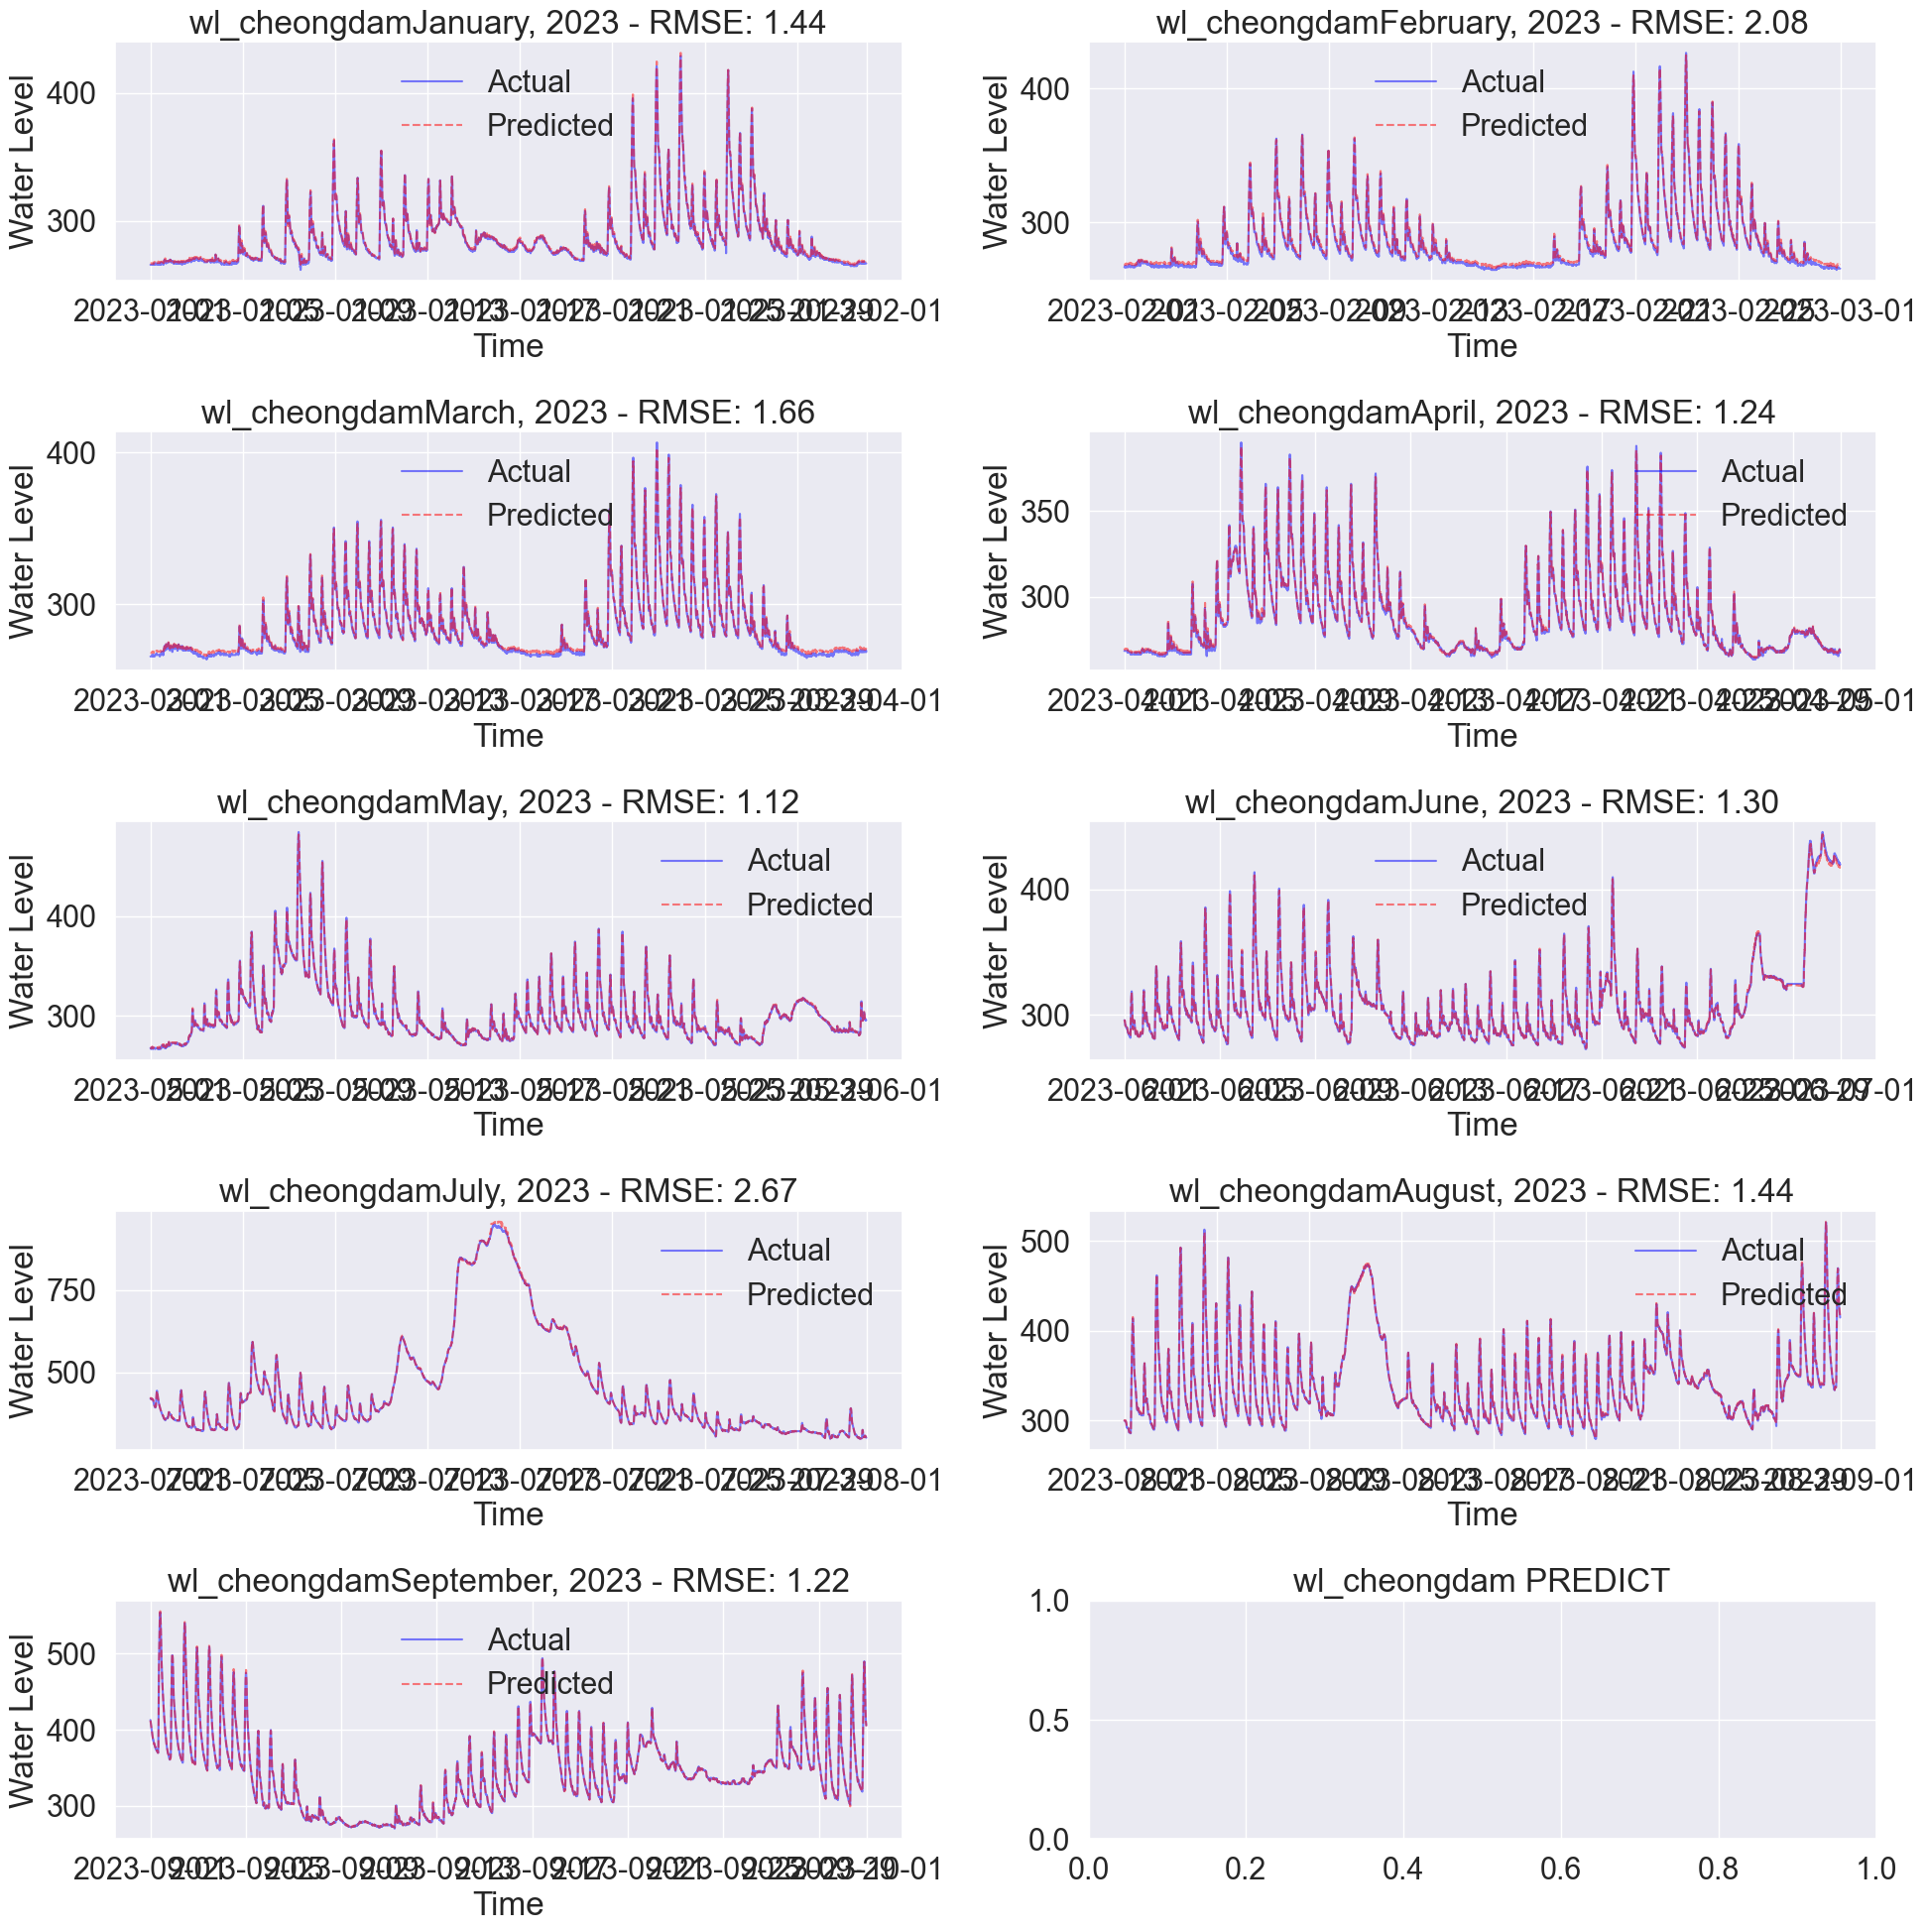

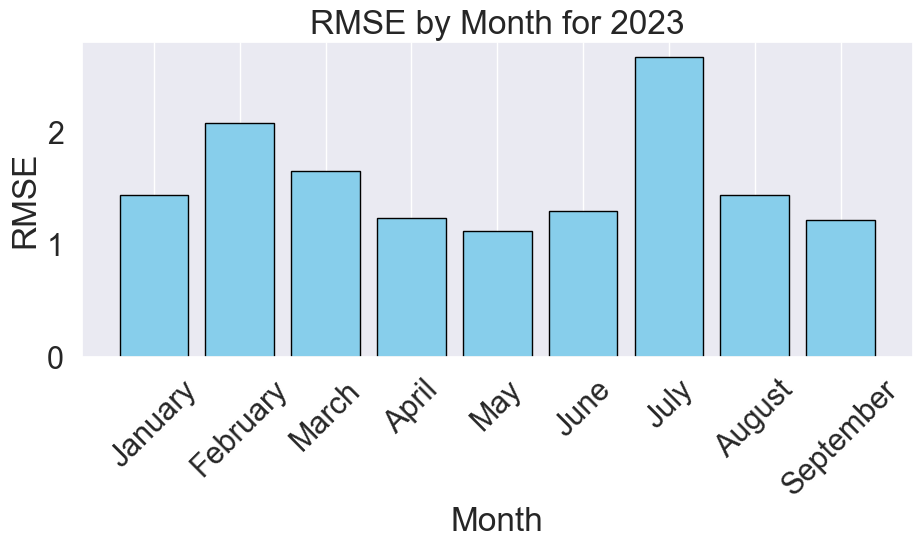

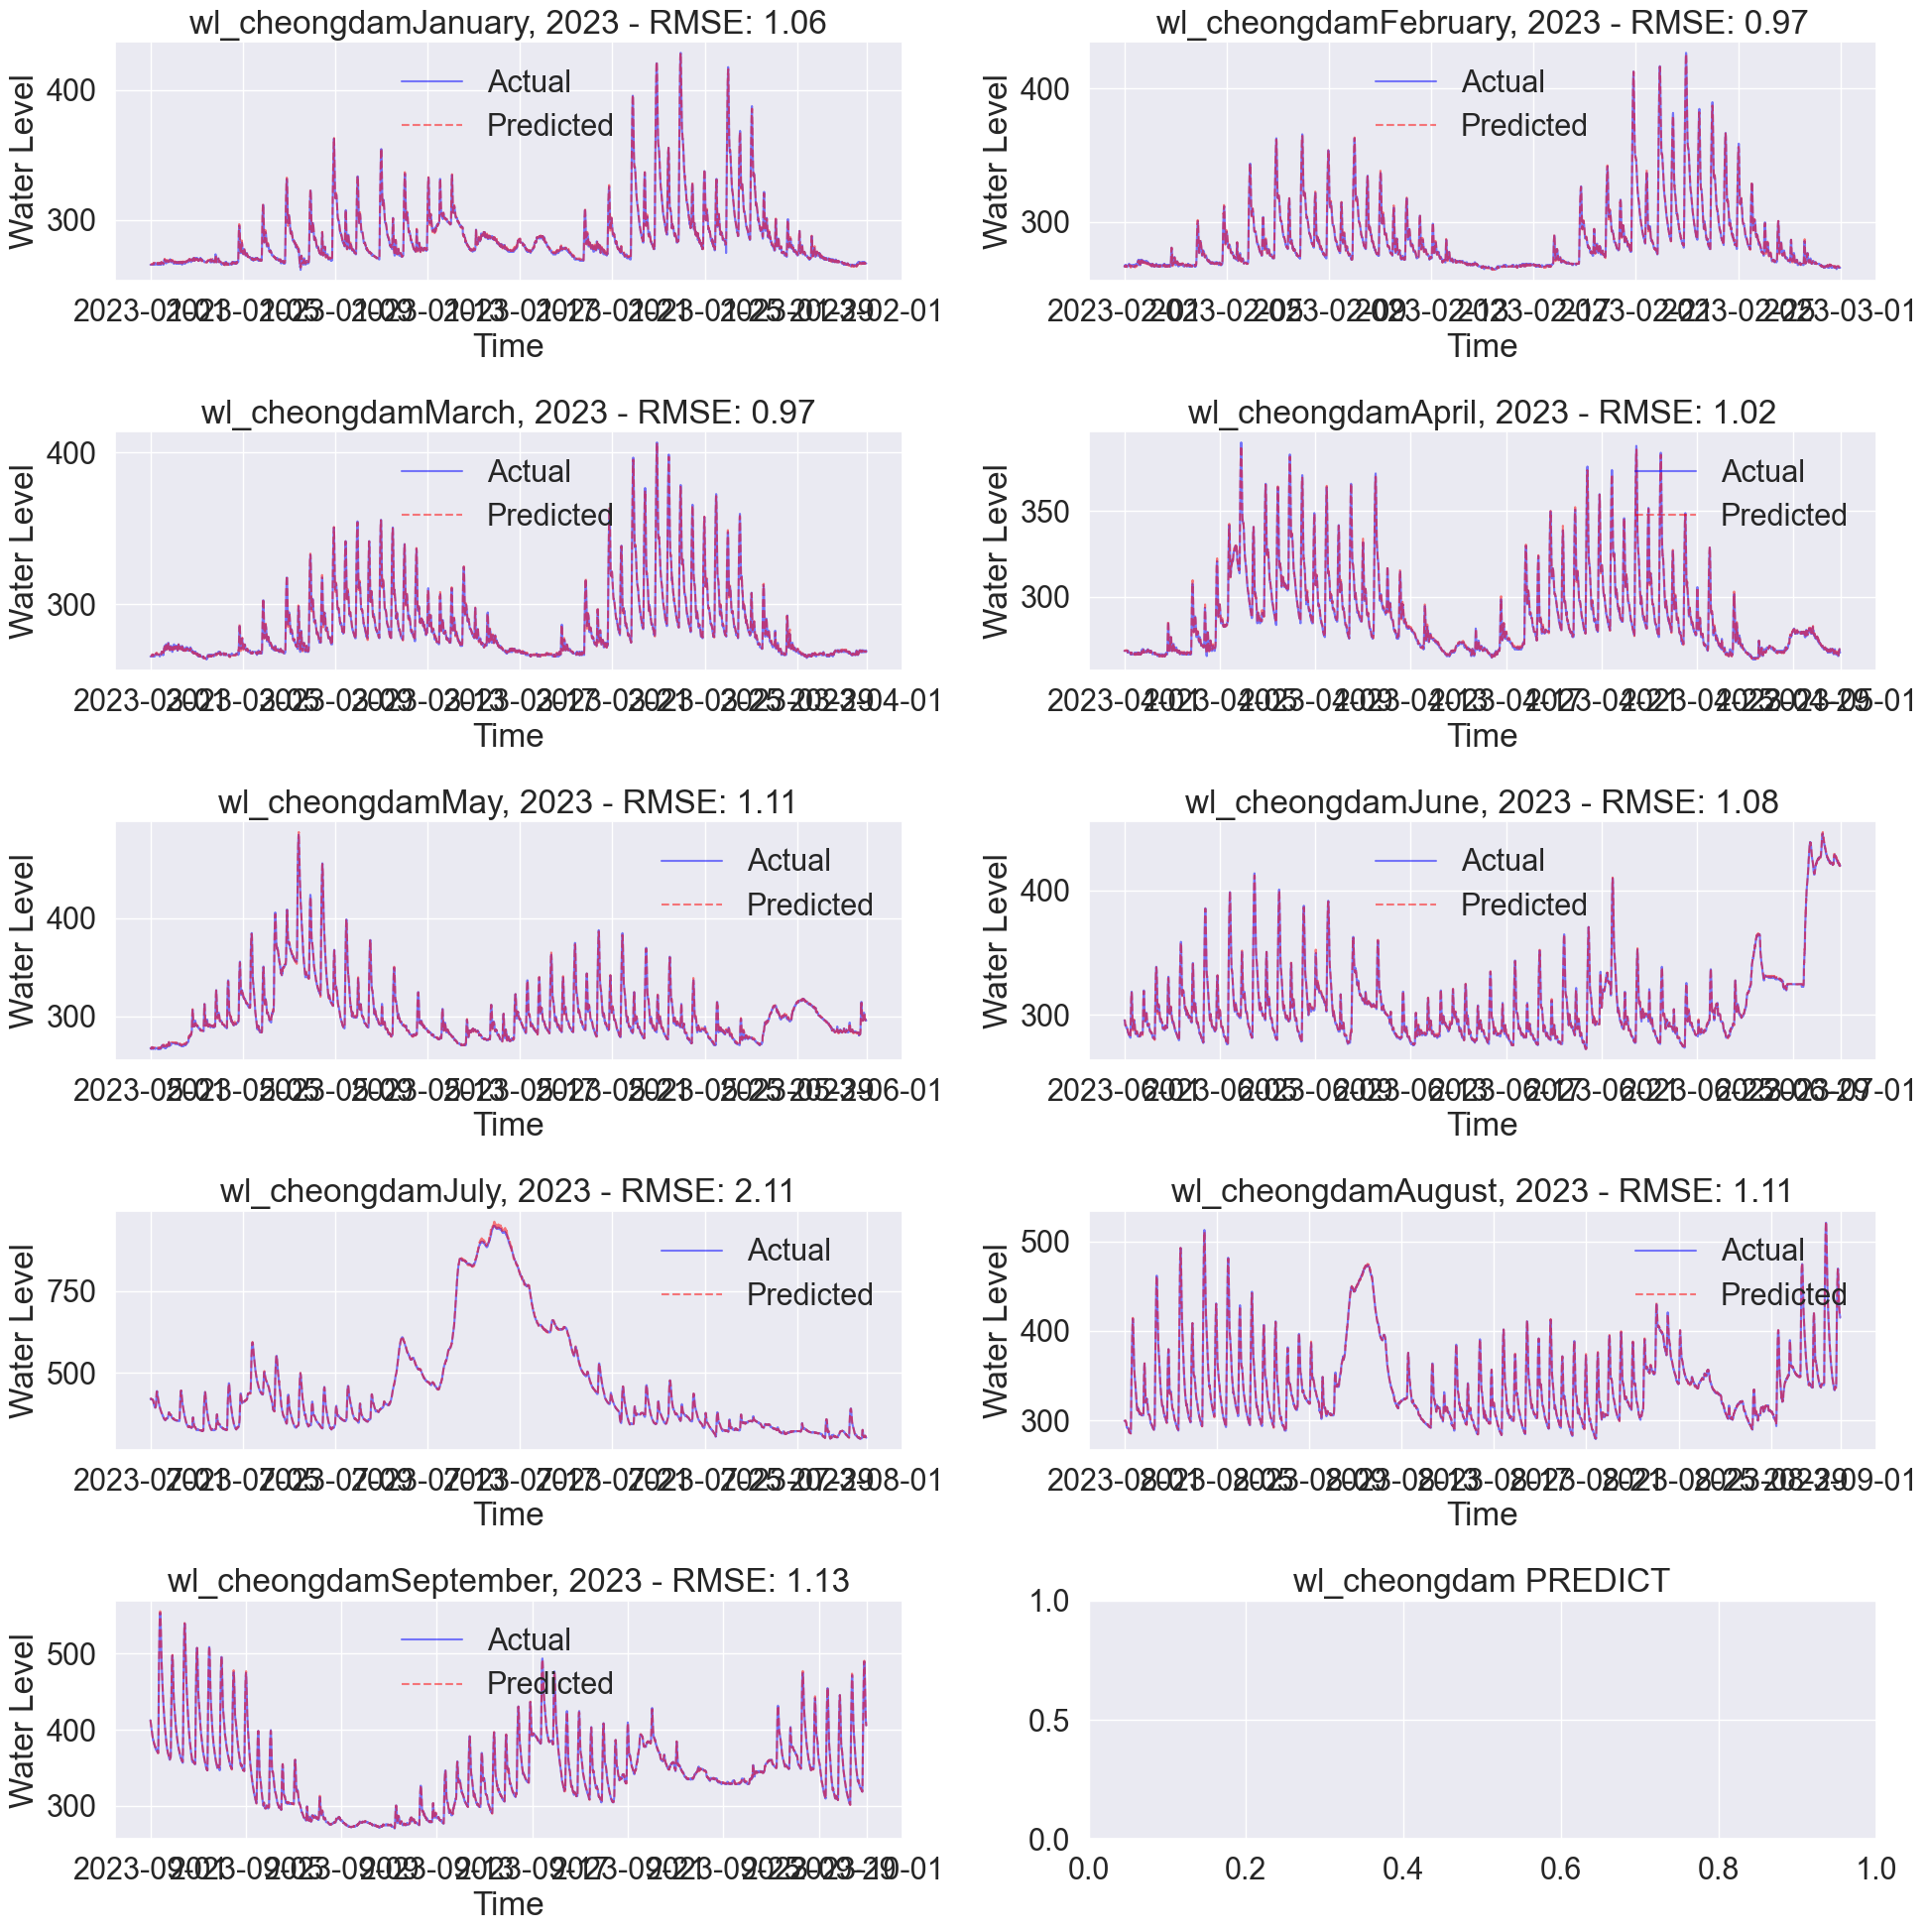

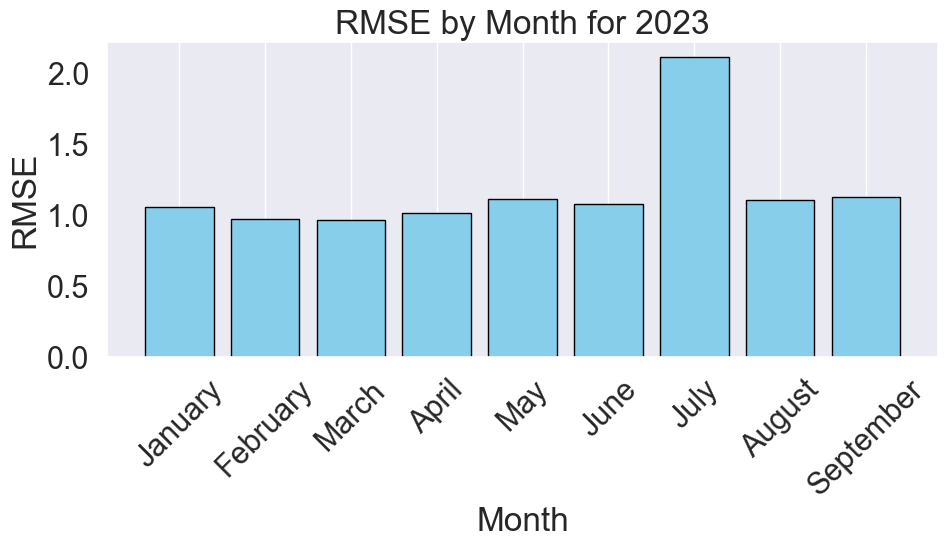

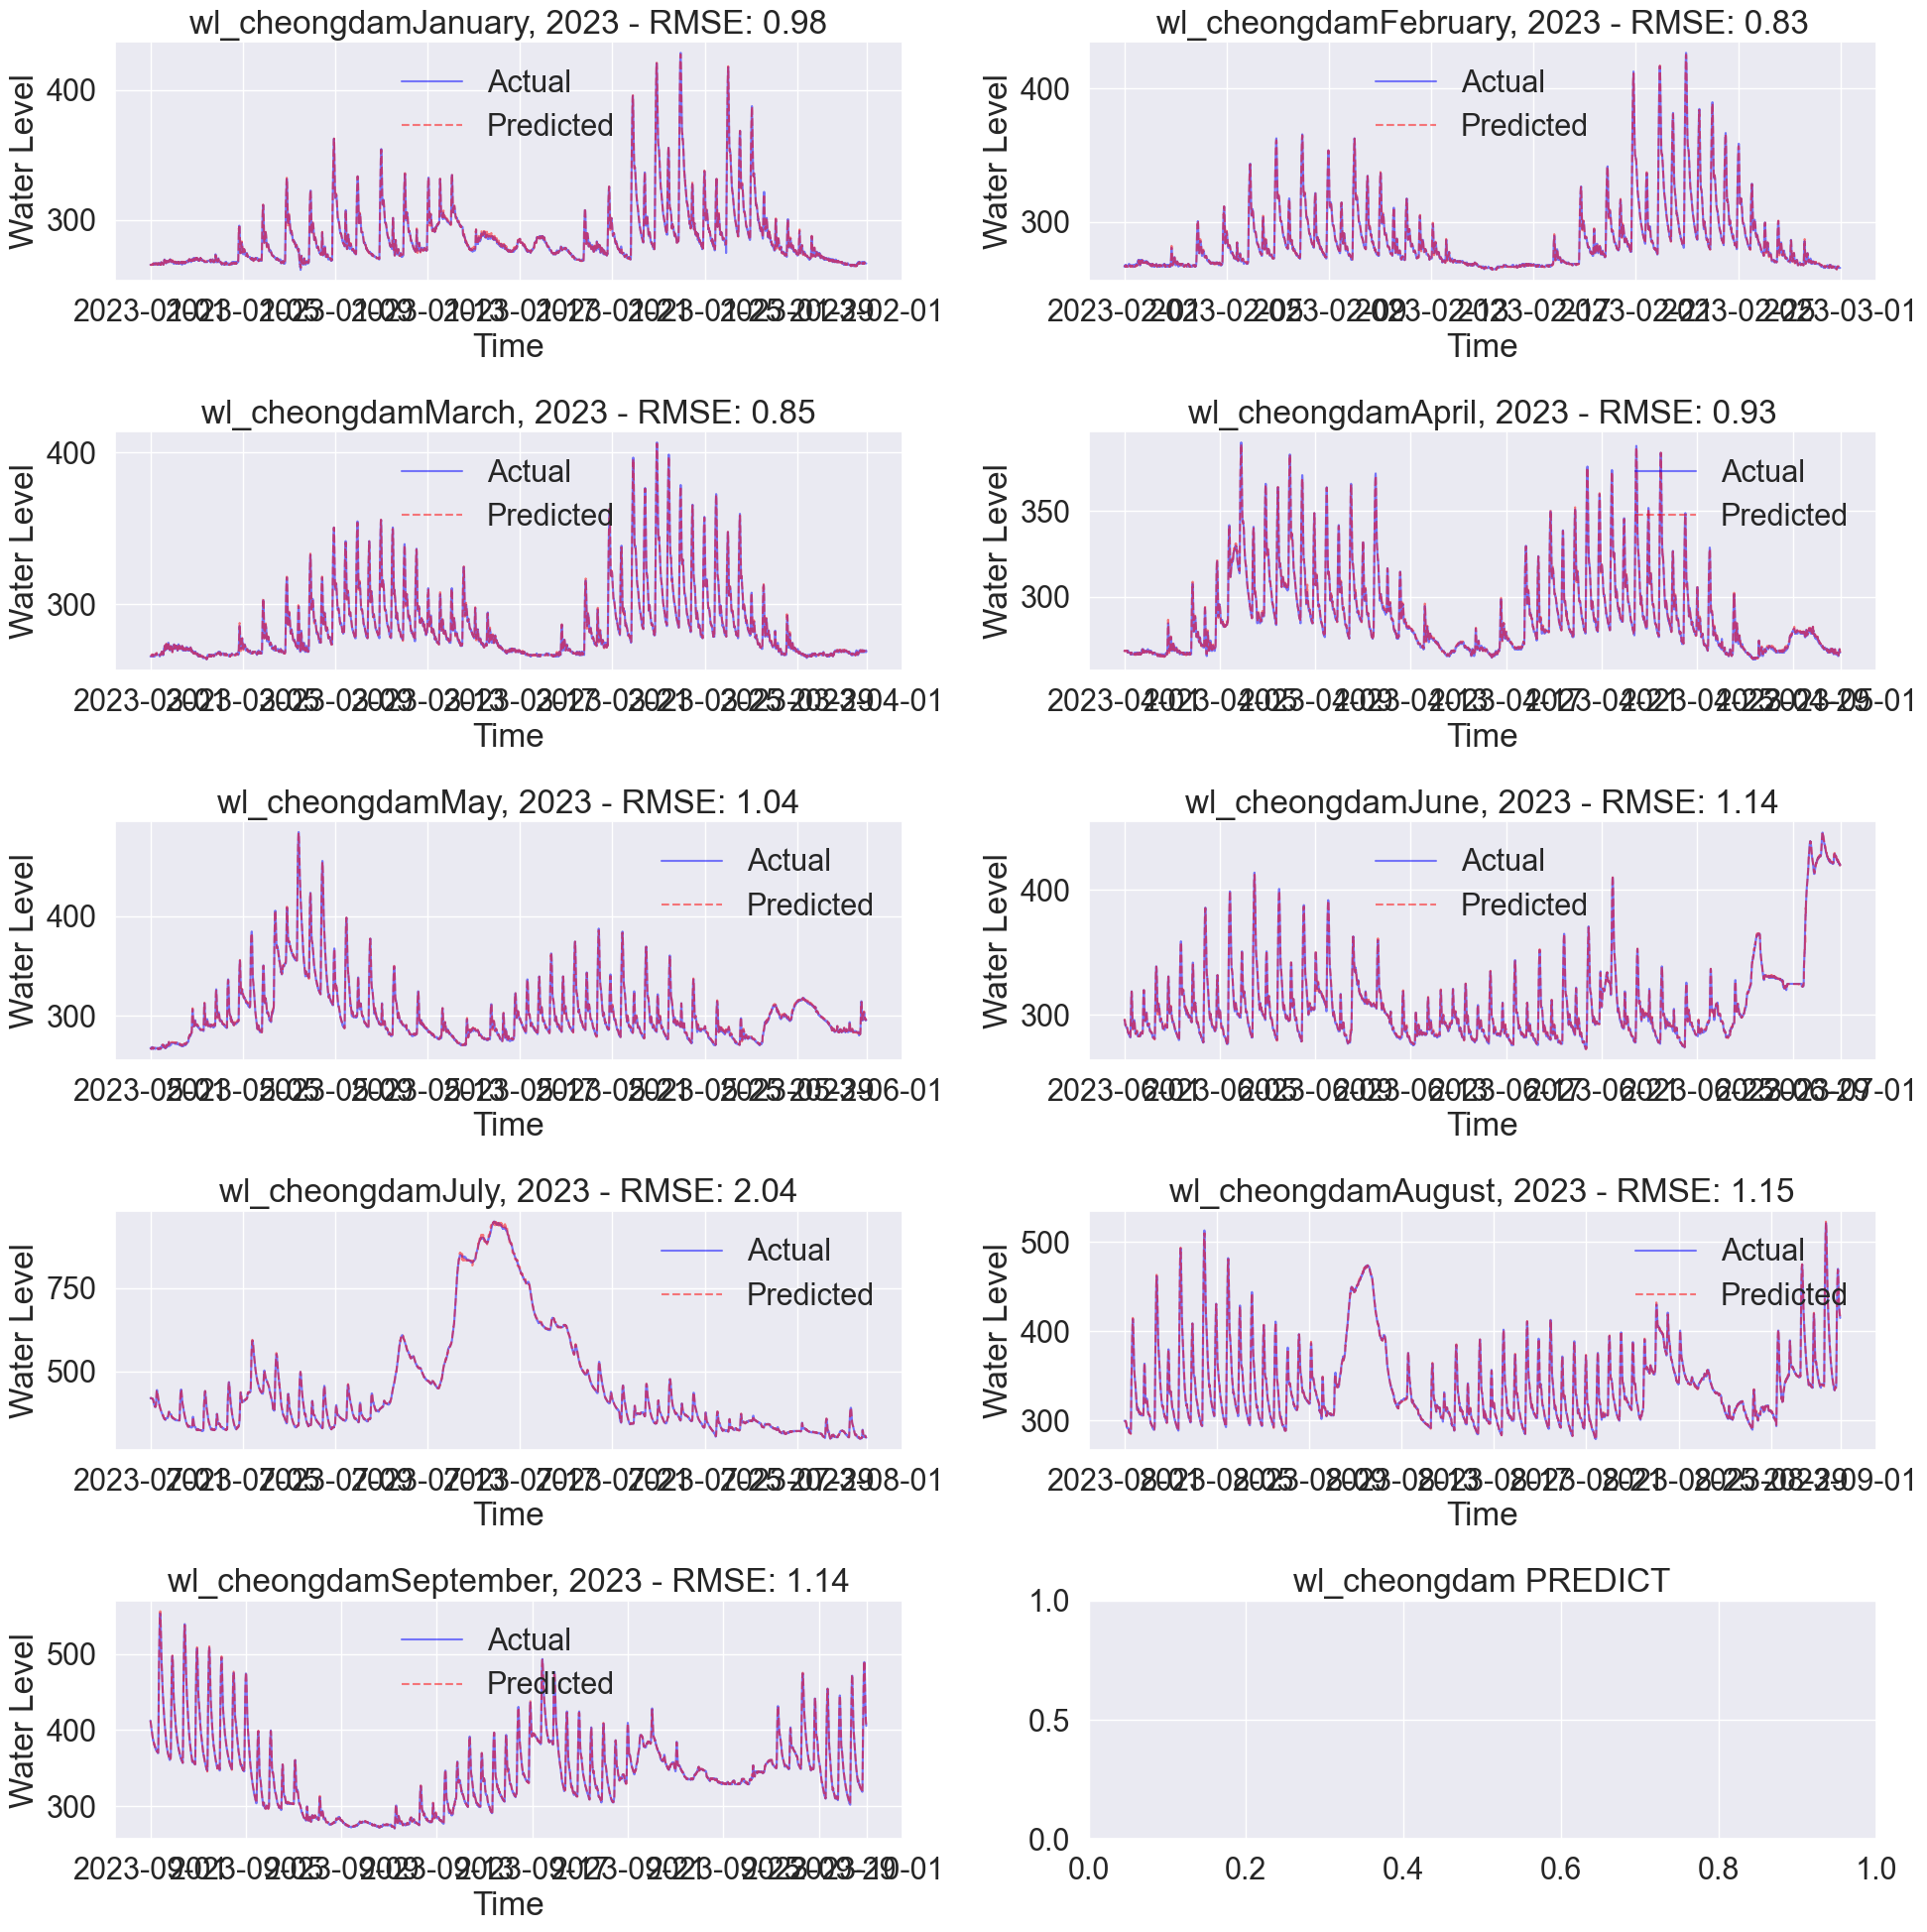

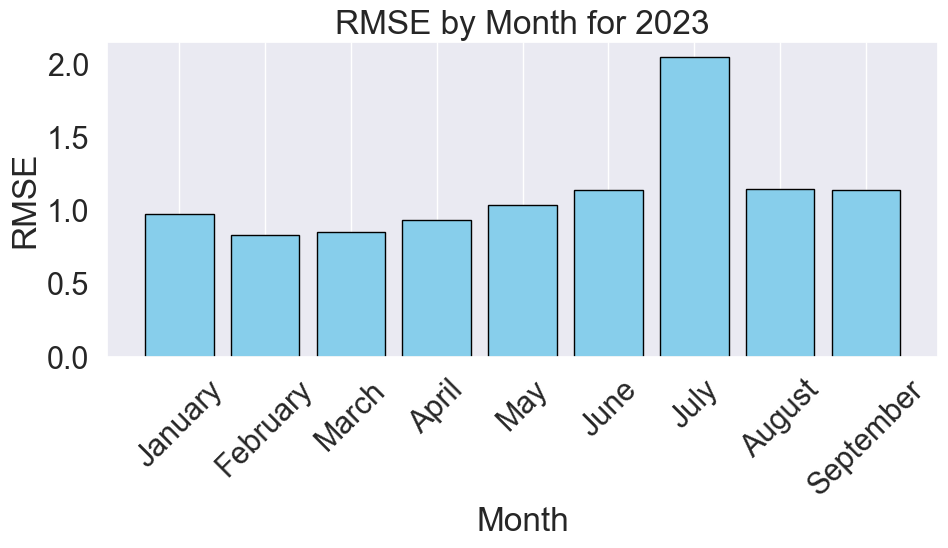

In [100]:
TARGET_BRIDGE='wl_cheongdam'
#plot_compare(answer,cheongdam_lt10_monthly)
#plot_compare(answer,cheongdam_lt10_flood)
#plot_compare(answer,cheongdam_lt10_total)
plot_month(answer,cheongdam_lt10_monthly,10)
plot_month(answer,cheongdam_lt10_flood,10)
plot_month(answer,cheongdam_lt10_total,10)

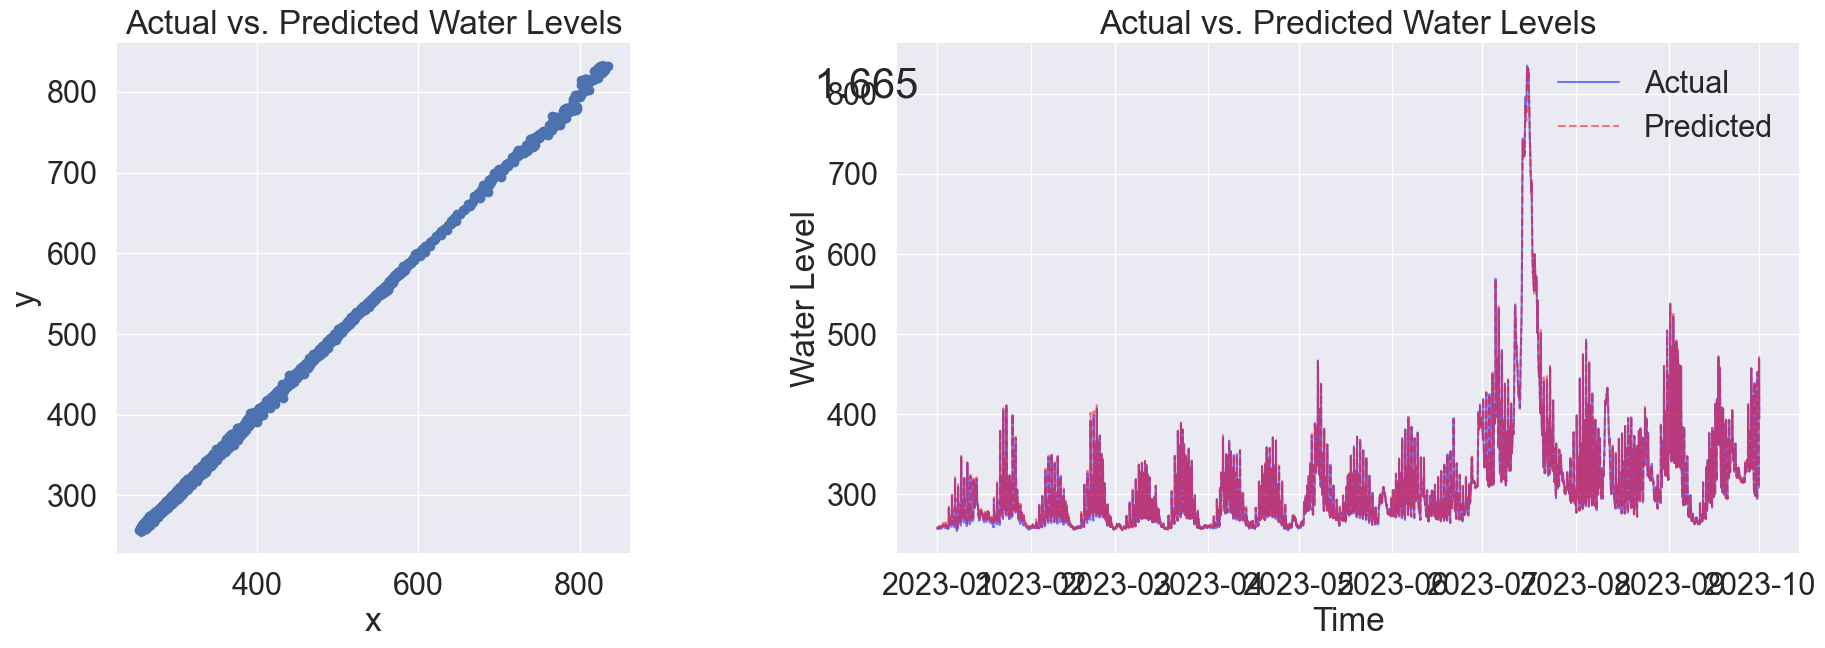

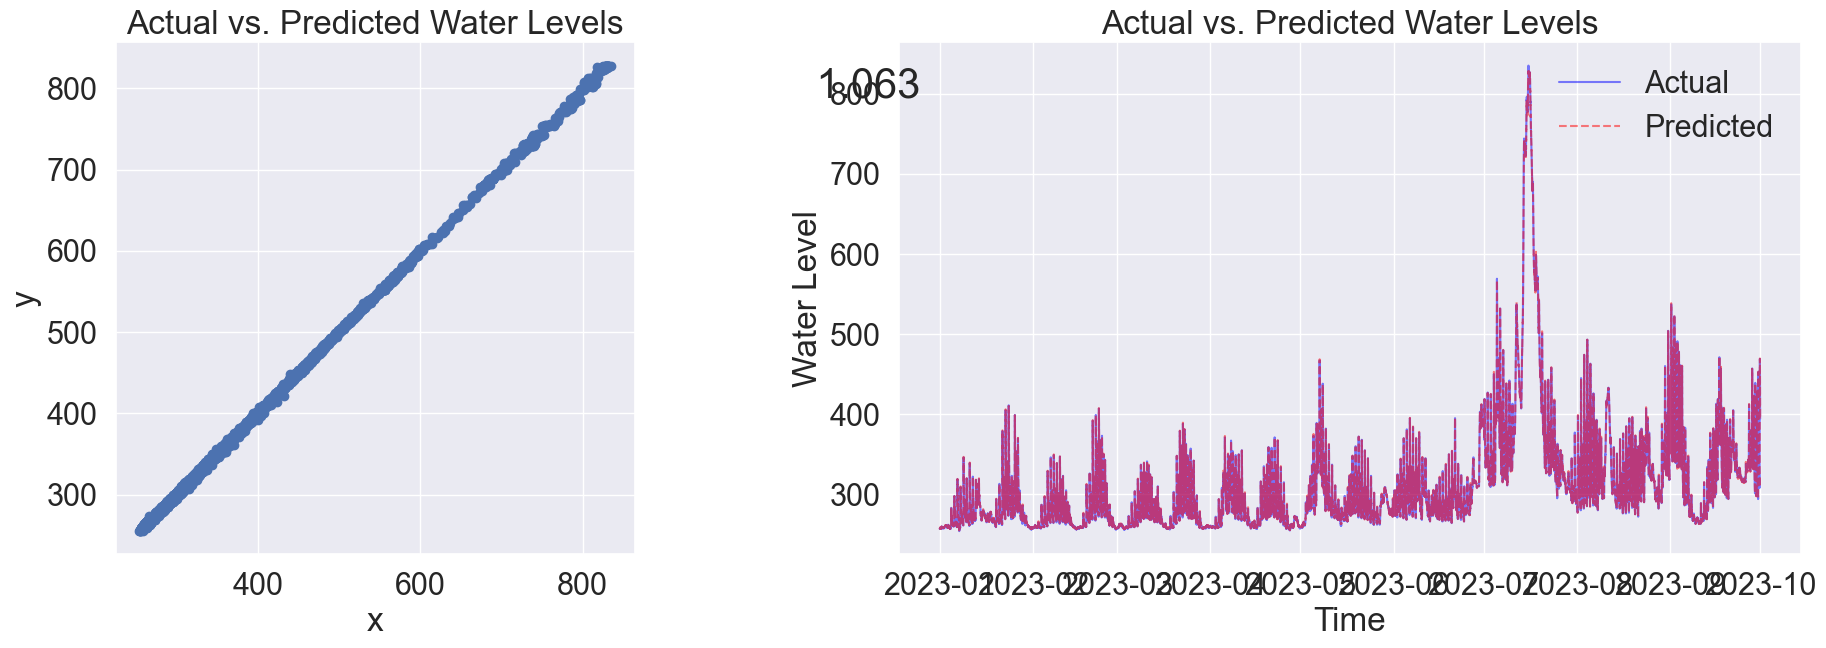

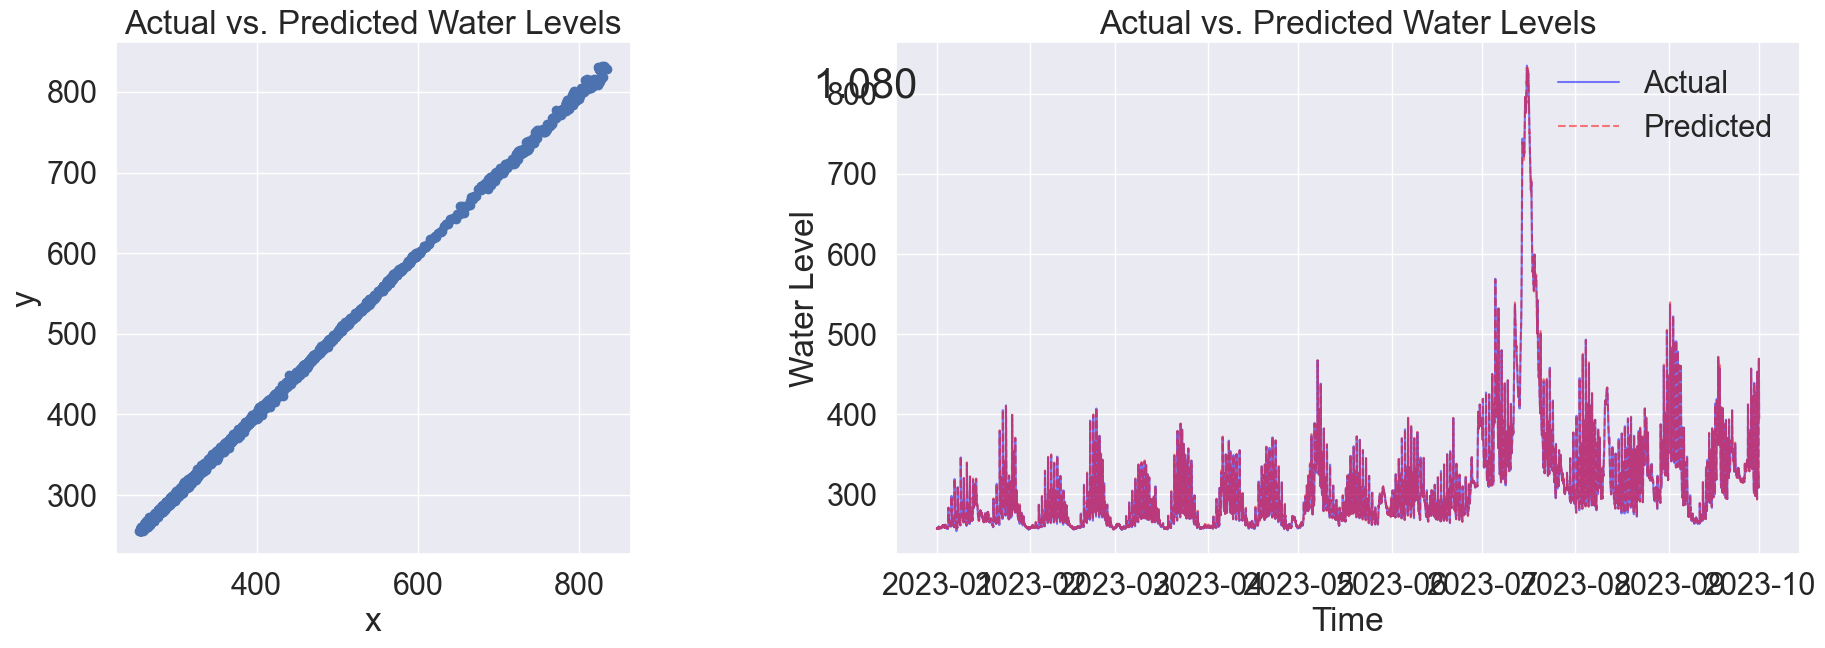

In [101]:
TARGET_BRIDGE='wl_jamsu'
plot_compare(answer,jamsu_lt10_monthly)
plot_compare(answer,jamsu_lt10_flood)
plot_compare(answer,jamsu_lt10_total)

# 모델 선정

In [102]:
# 3개의 모델(전체월, 비홍수기, 홍수기)을 이용하여 test 셋의 rmse를 가장 잘 예측한 모델을 확인.
def finalize_modeling(leadtime,bridge):
    overall_rmse_list = []
  
    print("#" * 50)
    print(f"{bridge} Predict report for Leadtime {leadtime}:\n")
    
    # 변수명들을 동적으로 불러올 수 있도록 globals()사용 
    results = [globals()[f"{bridge}_lt{leadtime}_monthly"], globals()[f"{bridge}_lt{leadtime}_flood"], globals()[f"{bridge}_lt{leadtime}_total"]]
    rmse_best = pd.DataFrame(index=range(1, 10), columns=['Model 1', 'Model 2', 'Model 3', 'Best Model'])

    for month in range(1, 10):
        best_rmse, best_model_name = float('inf'), None
        for i, model in enumerate(results):
            model.index = pd.to_datetime(model.index)
            model_month = model[model.index.month == month]
            answer_month = answer[answer.index.month == month]['wl_'+bridge]

            if not model_month.empty and not answer_month.empty:
                rmse = mean_squared_error(answer_month, model_month,squared=False)
                rmse_best.loc[month, f'Model {i+1}'] = rmse

                if rmse < best_rmse:
                    best_rmse, best_model_name = rmse, f'Model {i+1}'

        rmse_best.loc[month, 'Best Model'] = best_model_name

    print(rmse_best)

    best_model_rmse = [rmse_best.loc[month, best_model] for month, best_model in enumerate(rmse_best['Best Model'], start=1)]
    overall_rmse = np.sqrt(np.mean(np.square(best_model_rmse)))
    overall_rmse_list.append(overall_rmse)
    return overall_rmse


In [103]:
cheongdam_res = finalize_modeling(10,'cheongdam')
jamsu_res = finalize_modeling(10,'jamsu')
hangang_res = finalize_modeling(10,'hangang')
haengju_res = finalize_modeling(10,'haengju')

##################################################
cheongdam Predict report for Leadtime 10:

    Model 1   Model 2   Model 3 Best Model
1  1.440758  1.057279  0.976064    Model 3
2  2.082173  0.973827  0.833679    Model 3
3  1.657138  0.967026  0.852477    Model 3
4  1.236435  1.019958   0.93333    Model 3
5  1.119611   1.11314  1.039946    Model 3
6  1.299643  1.082404  1.141472    Model 2
7  2.665191  2.113946  2.044776    Model 3
8  1.439435  1.110273  1.148527    Model 2
9  1.220594  1.130641  1.143941    Model 2
##################################################
jamsu Predict report for Leadtime 10:

    Model 1   Model 2   Model 3 Best Model
1  2.521352   0.94188  0.968563    Model 2
2  2.094357  0.848641   0.92035    Model 2
3   0.99771  0.811815  0.879496    Model 2
4  1.451273  0.970316  1.036464    Model 2
5  1.257868  1.030421  0.959773    Model 3
6  1.168648  0.926941  0.928146    Model 2
7  2.395861  1.744445  1.812453    Model 2
8  1.094809  0.983839  0.935401    Model 3